In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import time
start = time.time()

In [2]:
def fill_missing(data):
            
    data = data.replace(" ?", np.nan)
    
    for col in missing_col:
        top = data[col].describe().top
        data[col] = data[col].fillna(value=top)
        
    return data

In [3]:
def get_var(dataframe):
    
    get_vars = []
    for col in dataframe.columns:
        if dataframe[col].dtype == "object":
            get_vars.append(col)

    return get_vars

In [4]:
def reshape_data(dataframe,encoder = "label"):
    
    
    # using onehot for va
    if encoder == "label":
        df_trans = var_numeric(dataframe)
    else:
        var_feature = get_var(dataframe)
        df_num = dataframe.drop(var_feature,axis=1)
        df_var = dataframe[var_feature]

        df_trans = pd.get_dummies(df_var)
        #df_trans.columns =["col{0}".format(i) for i in range(df_trans.shape[1])]
        
        for col in list(df_num.columns):
            #df_trans.loc[:,col] = df_num[col].astype("int64")
            df_trans[col] = sklearn.preprocessing.minmax_scale(df_num[col])
            #df_trans[col] = df_num[col]
    
    
    # some columns would cause conflic when using algorithm
    
    df_trans.rename(columns={"max_glu_serum_>200":"max_glu_serum_200","max_glu_serum_>300":"max_glu_serum_300","A1Cresult_>7":"A1Cresult_7","A1Cresult_>8":"A1Cresult_8"})
    return df_trans

In [5]:
def plot_Curve(dic,y_test):
    plt.figure(figsize=(20,20))
    for key in dic.keys():
        pred=dic.get(key)
        # plot PR Curve
        plt.subplot(211)
        pr, re, _ = sklearn.metrics.precision_recall_curve(y_test,pred)
        plt.plot(re,pr,label=key,linewidth = 3)
        plt.legend(loc='best',prop = {"size":20})
        plt.xlabel('Recall',fontsize ='20' )
        plt.ylabel('Precision',fontsize= '20' )
        plt.title("PR_Curve")
        
        #plot ROC Curve
        plt.subplot(212)
        fpr, tpr, _  = sklearn.metrics.roc_curve(y_test,pred)
        plt.plot(fpr,tpr,label=key,linewidth = 3)
        plt.legend(loc='best',prop = {"size":20})
        plt.xlabel('False Positive Rate',fontsize ='20')
        plt.ylabel('True Positive Rate',fontsize= '20' )
        plt.title("ROC_Curve")

In [6]:
path = 'dataset_diabetes/diabetic_data.csv'
df = pd.read_csv(path)
df.loc[df.readmitted=="NO","readmitted"]=">30"

In [7]:
df.shape

(101766, 50)

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,>30
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,>30
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,>30
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [10]:

missing_num = np.sum(np.array(df) == "?",axis =0)
missing_filter  = missing_num>0
missing_col = df.columns[missing_filter]

missing_df = pd.DataFrame(
{"number of missing":missing_num[missing_filter],"pecentage":missing_num[missing_filter>0]/df.shape[0]*100},index= missing_col).T
missing_df

,race,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3
number of missing,2273.000000,98569.000000,40256.000000,49949.000000,21.000000,358.000000,1423.000000
pecentage,2.233555,96.858479,39.557416,49.082208,0.020636,0.351787,1.398306


In [11]:
# medications' name
medications_name = df.columns[24:-3]
df=fill_missing(df)

# count the total reaction of 
df["num_no"] = np.sum(df[medications_name]=="No",axis=1)
df["num_down"] = np.sum(df[medications_name]=="Down",axis=1)
df["num_steady"] = np.sum(df[medications_name]=="Steady",axis=1)
df["num_up"] = np.sum(df[medications_name]=="Up",axis=1)


# count come back times of each patients in this table
df["comback_times"]=df.patient_nbr.map(df.patient_nbr.value_counts())

# count people visit hospital times
df["countyear_visit"]=df[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)


gmm_features = df[["num_lab_procedures","num_procedures","num_medications","comback_times","time_in_hospital"]]
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(gmm_features)

gmm_label = ["gmm_1","gmm_2","gmm_3","gmm_4","gmm_5"]
a=pd.DataFrame(gmm.predict_proba(gmm_features)*20,columns=gmm_label)
df=df.merge(a,left_index =True,right_index=True)

# 1.4. Transform feature¶


In [12]:
# transfer label to numeric
df["readmitted"] = sklearn.preprocessing.LabelEncoder().fit_transform(df["readmitted"])

# transform feature "weight"

df.loc[:,"weight"] = df["weight"].replace("?",0)
df.loc[:,"weight"] = df["weight"].replace("\>|\[|\-.*","",regex=True).astype("float")

# reclassfy the discarge type into bigger category
df.loc[:,"age"] = df["age"].replace("\[|\-.*","",regex=True).astype("int64")
# unknown
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([18,25,26],0) # not mentioned
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([1,6,8,13,14],1) # go home with assistance
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([2,3,4,5],2) # need help
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([9,10,12,13,14,15,16,17,22,23,24],3)
df.loc[:,"discharge_disposition_id"]=df["discharge_disposition_id"].replace([11,19,20,21],4) #die

# Change diag code to bigger classfication
# base on the standard of ICD-9 format

dignose_col = ["diag_1","diag_2","diag_3"]
diag_code = [-1,0,139,239,279,289,319,389,459,519,579,629,679,709,739,759,779,799,999,1999,2001]
df.loc[:,dignose_col]=df[dignose_col].replace("^\?",0,regex=True)
df.loc[:,dignose_col]=df[dignose_col].replace("^V",1000,regex=True)
df.loc[:,dignose_col]=df[dignose_col].replace("^E",2000,regex=True)

df[dignose_col].astype("float64")
for i in dignose_col:
    df.loc[:,i] = pd.cut(pd.to_numeric(df[i]),diag_code,labels = False)

In [20]:
# drop features
ratio = df[df["readmitted"]==0].shape[0]/df[df["readmitted"]==1].shape[0]
label = df["readmitted"]
features = df.drop(["readmitted","encounter_id","patient_nbr"],axis=1)
features = features.drop(medications_name,axis=1)

In [21]:
features.shape

(101766, 35)

# 2. Machine Learning
2.1. Rebalance Data and split train/test set

In [22]:
# use reshape fuction to transform the rest of features
features = reshape_data(features,encoder = "onehot")

In [23]:

X_train, X_test, y_train, y_test=sklearn.model_selection.train_test_split(features, label, test_size=0.3)




In [35]:
X_train.shape[1]

139

In [36]:
sig = lambda z: np.atleast_2d(np.arctan(z))
dsig = lambda z: np.atleast_2d(1/(1+ np.power(z, 2)))
#We choose L=2,N=7
w=[X_train.shape[1],139,7,2]
#Define Arctan as activation function
nn_atan=ml.nnet.nnetClassify()
nn_atan.init_weights(w, 'random', X_train, y_train)
nn_atan.setActivation('custom', sig, dsig)
nn_atan.train(X_train, y_train, stopTol=1e-8, stepsize=.25, stopIter=300)
tr1_auc_NN_atan=nn_atan.auc(X_train,y_train)
va1_auc_NN_atan=nn_atan.auc(X_test,y_test)


print('Validation AUC Arctan=',va1_auc_NN_atan, ' & Train AUC Arctan=', tr1_auc_NN_atan)

KeyError: 0

In [25]:
X_train.shape

(71236, 139)

In [26]:
y_train.shape

(71236,)

In [32]:
X_test.shape

(30530, 139)

In [33]:
y_test.shape

(30530,)

In [28]:
import numpy as np 
import mltools as ml
import matplotlib.pyplot as plt

In [30]:
X_train.shape[1]

139

In [42]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(6, ), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)



-- Training data --
Accuracy: 88.86
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.03      0.06      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.68      0.51      0.50     71236
weighted avg       0.85      0.89      0.84     71236

Confusion Matrix:
[[  234  7682]
 [  257 63063]]


---- Test data ----
Accuracy: 88.61
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.03      0.05      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.65      0.51      0.50     30530
weighted avg       0.84      0.89      0.84     30530

Confusion Matrix:
[[   97  3344]
 [  134 26955]]


In [48]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200, 100, 30), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 97.99
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      7916
           1       0.98      0.99      0.99     63320

    accuracy                           0.98     71236
   macro avg       0.97      0.93      0.95     71236
weighted avg       0.98      0.98      0.98     71236

Confusion Matrix:
[[ 6811  1105]
 [  324 62996]]


---- Test data ----
Accuracy: 83.72
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.18      0.20      3441
           1       0.90      0.92      0.91     27089

    accuracy                           0.84     30530
   macro avg       0.56      0.55      0.56     30530
weighted avg       0.82      0.84      0.83     30530

Confusion Matrix:
[[  630  2811]
 [ 2158 24931]]


In [49]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 50, 15), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 95.11
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      7916
           1       0.96      0.99      0.97     63320

    accuracy                           0.95     71236
   macro avg       0.93      0.81      0.86     71236
weighted avg       0.95      0.95      0.95     71236

Confusion Matrix:
[[ 4990  2926]
 [  558 62762]]


---- Test data ----
Accuracy: 84.27
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.18      0.21      3441
           1       0.90      0.93      0.91     27089

    accuracy                           0.84     30530
   macro avg       0.57      0.55      0.56     30530
weighted avg       0.82      0.84      0.83     30530

Confusion Matrix:
[[  619  2822]
 [ 1979 25110]]


In [50]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(50, 10, 7), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 91.07
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.25      0.39      7916
           1       0.91      0.99      0.95     63320

    accuracy                           0.91     71236
   macro avg       0.87      0.62      0.67     71236
weighted avg       0.90      0.91      0.89     71236

Confusion Matrix:
[[ 2002  5914]
 [  447 62873]]


---- Test data ----
Accuracy: 87.12
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.10      0.14      3441
           1       0.89      0.97      0.93     27089

    accuracy                           0.87     30530
   macro avg       0.59      0.53      0.54     30530
weighted avg       0.83      0.87      0.84     30530

Confusion Matrix:
[[  333  3108]
 [  825 26264]]


In [75]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(25, 5, 3), activation='logistic', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 88.89
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.44      0.50      0.47     71236
weighted avg       0.79      0.89      0.84     71236

Confusion Matrix:
[[    0  7916]
 [    0 63320]]


---- Test data ----
Accuracy: 88.73
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.44      0.50      0.47     30530
weighted avg       0.79      0.89      0.83     30530

Confusion Matrix:
[[    0  3441]
 [    0 27089]]


C:\Users\Marzhan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marzhan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 99.04
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7916
           1       0.99      1.00      0.99     63320

    accuracy                           0.99     71236
   macro avg       0.98      0.97      0.98     71236
weighted avg       0.99      0.99      0.99     71236

Confusion Matrix:
[[ 7470   446]
 [  236 63084]]


---- Test data ----
Accuracy: 83.03
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.22      0.23      3441
           1       0.90      0.91      0.90     27089

    accuracy                           0.83     30530
   macro avg       0.57      0.56      0.57     30530
weighted avg       0.83      0.83      0.83     30530

Confusion Matrix:
[[  759  2682]
 [ 2499 24590]]


In [53]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 95.40
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      7916
           1       0.96      0.99      0.97     63320

    accuracy                           0.95     71236
   macro avg       0.91      0.85      0.87     71236
weighted avg       0.95      0.95      0.95     71236

Confusion Matrix:
[[ 5585  2331]
 [  949 62371]]


---- Test data ----
Accuracy: 83.26
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.21      0.22      3441
           1       0.90      0.91      0.91     27089

    accuracy                           0.83     30530
   macro avg       0.57      0.56      0.56     30530
weighted avg       0.83      0.83      0.83     30530

Confusion Matrix:
[[  722  2719]
 [ 2393 24696]]


In [54]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(50,25), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 91.22
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.32      0.44      7916
           1       0.92      0.99      0.95     63320

    accuracy                           0.91     71236
   macro avg       0.83      0.65      0.70     71236
weighted avg       0.90      0.91      0.90     71236

Confusion Matrix:
[[ 2495  5421]
 [  837 62483]]


---- Test data ----
Accuracy: 86.38
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.12      0.17      3441
           1       0.90      0.96      0.93     27089

    accuracy                           0.86     30530
   macro avg       0.58      0.54      0.55     30530
weighted avg       0.83      0.86      0.84     30530

Confusion Matrix:
[[  426  3015]
 [ 1142 25947]]


In [55]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(25,12), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 89.85
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.18      0.29      7916
           1       0.91      0.99      0.95     63320

    accuracy                           0.90     71236
   macro avg       0.78      0.59      0.62     71236
weighted avg       0.88      0.90      0.87     71236

Confusion Matrix:
[[ 1448  6468]
 [  765 62555]]


---- Test data ----
Accuracy: 87.36
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.09      0.14      3441
           1       0.89      0.97      0.93     27089

    accuracy                           0.87     30530
   macro avg       0.60      0.53      0.54     30530
weighted avg       0.83      0.87      0.84     30530

Confusion Matrix:
[[  314  3127]
 [  731 26358]]


In [56]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(12,4), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 89.05
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.04      0.07      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.75      0.52      0.51     71236
weighted avg       0.86      0.89      0.85     71236

Confusion Matrix:
[[  315  7601]
 [  199 63121]]


---- Test data ----
Accuracy: 88.64
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.03      0.06      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.67      0.51      0.50     30530
weighted avg       0.84      0.89      0.84     30530

Confusion Matrix:
[[  106  3335]
 [  133 26956]]


In [58]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(50), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 89.52
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.09      0.17      7916
           1       0.90      1.00      0.94     63320

    accuracy                           0.90     71236
   macro avg       0.81      0.54      0.55     71236
weighted avg       0.88      0.90      0.86     71236

Confusion Matrix:
[[  739  7177]
 [  287 63033]]


---- Test data ----
Accuracy: 88.34
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.05      0.09      3441
           1       0.89      0.99      0.94     27089

    accuracy                           0.88     30530
   macro avg       0.63      0.52      0.51     30530
weighted avg       0.83      0.88      0.84     30530

Confusion Matrix:
[[  178  3263]
 [  298 26791]]


In [59]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(25), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 89.24
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.07      0.12      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.78      0.53      0.53     71236
weighted avg       0.87      0.89      0.85     71236

Confusion Matrix:
[[  515  7401]
 [  261 63059]]


---- Test data ----
Accuracy: 88.52
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.04      0.07      3441
           1       0.89      0.99      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.65      0.52      0.51     30530
weighted avg       0.84      0.89      0.84     30530

Confusion Matrix:
[[  137  3304]
 [  201 26888]]


In [60]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(12), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 88.88
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.06      0.11      7916
           1       0.89      0.99      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.70      0.53      0.53     71236
weighted avg       0.85      0.89      0.85     71236

Confusion Matrix:
[[  498  7418]
 [  500 62820]]


---- Test data ----
Accuracy: 88.31
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.05      0.08      3441
           1       0.89      0.99      0.94     27089

    accuracy                           0.88     30530
   macro avg       0.62      0.52      0.51     30530
weighted avg       0.83      0.88      0.84     30530

Confusion Matrix:
[[  156  3285]
 [  285 26804]]


In [61]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=25, activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 89.12
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.07      0.12      7916
           1       0.90      0.99      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.74      0.53      0.53     71236
weighted avg       0.86      0.89      0.85     71236

Confusion Matrix:
[[  542  7374]
 [  375 62945]]


---- Test data ----
Accuracy: 88.39
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.05      0.08      3441
           1       0.89      0.99      0.94     27089

    accuracy                           0.88     30530
   macro avg       0.63      0.52      0.51     30530
weighted avg       0.83      0.88      0.84     30530

Confusion Matrix:
[[  157  3284]
 [  260 26829]]


In [62]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=6, activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 88.90
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.01      0.03      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.71      0.51      0.48     71236
weighted avg       0.85      0.89      0.84     71236

Confusion Matrix:
[[  110  7806]
 [  100 63220]]


---- Test data ----
Accuracy: 88.66
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.01      0.02      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.64      0.50      0.48     30530
weighted avg       0.83      0.89      0.84     30530

Confusion Matrix:
[[   36  3405]
 [   57 27032]]


In [63]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=3, activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 88.90
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.02      0.03      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.70      0.51      0.49     71236
weighted avg       0.85      0.89      0.84     71236

Confusion Matrix:
[[  137  7779]
 [  131 63189]]


---- Test data ----
Accuracy: 88.73
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.03      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.69      0.51      0.49     30530
weighted avg       0.84      0.89      0.84     30530

Confusion Matrix:
[[   54  3387]
 [   55 27034]]


In [67]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(3,3), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 88.89
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7916
           1       0.89      1.00      0.94     63320

    accuracy                           0.89     71236
   macro avg       0.44      0.50      0.47     71236
weighted avg       0.79      0.89      0.84     71236

Confusion Matrix:
[[    0  7916]
 [    0 63320]]


---- Test data ----
Accuracy: 88.73
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3441
           1       0.89      1.00      0.94     27089

    accuracy                           0.89     30530
   macro avg       0.44      0.50      0.47     30530
weighted avg       0.79      0.89      0.83     30530

Confusion Matrix:
[[    0  3441]
 [    0 27089]]


C:\Users\Marzhan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marzhan\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)
# Train the model on the whole data set
model.fit(X_train, y_train)
    # Save the model (Make sure that the folder exists)
    # Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')
    # Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


-- Training data --
Accuracy: 91.00
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.33      0.45      7916
           1       0.92      0.98      0.95     63320

    accuracy                           0.91     71236
   macro avg       0.81      0.66      0.70     71236
weighted avg       0.90      0.91      0.90     71236

Confusion Matrix:
[[ 2634  5282]
 [ 1126 62194]]


---- Test data ----
Accuracy: 86.04
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.14      0.18      3441
           1       0.90      0.95      0.92     27089

    accuracy                           0.86     30530
   macro avg       0.58      0.54      0.55     30530
weighted avg       0.83      0.86      0.84     30530

Confusion Matrix:
[[  471  2970]
 [ 1293 25796]]


In [ ]:
va_auc_NN

In [ ]:
N = 

In [71]:
L=range(1,4)
N=[4, 7, 15, 25, 50, 100]

In [68]:
va_auc_NN = [[0.887, .886, 0.8831,0.8839, 0.8834, 0.88], [0.87, .88, 0.87,0.86, 0.83, 0.83 ], [0, 0, 0.88, .87, 0.84,0.83 ]]

In [69]:
tr_auc_NN = [[0.889, .889, 0.8888,0.8812, 0.8852, 0.89], [0.89, .89, 0.89,0.91, 0.95, 0.99 ], [0, 0, 0.89, .91, 0.95,0.98 ]]

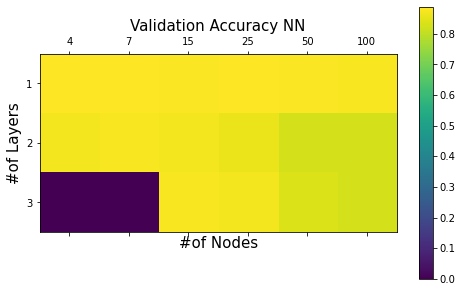

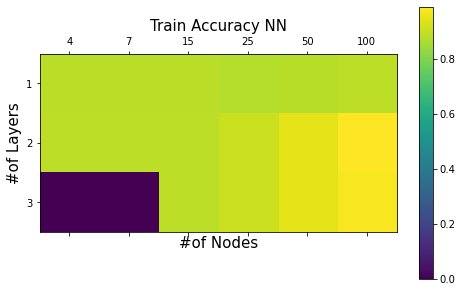

In [72]:
# Now plot it
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(va_auc_NN, interpolation='nearest')
f.colorbar(cax)
plt.title("Validation Accuracy NN",fontsize=15)
plt.xlabel("#of Nodes",fontsize=15)
plt.ylabel("#of Layers",fontsize=15)
plt.xticks(range(len(N)), N)
plt.yticks(range(len(L)), L)
plt.show()
#Train
f, ax = plt.subplots(1, 1, figsize=(8, 5))
cax = ax.matshow(tr_auc_NN, interpolation='nearest')
f.colorbar(cax)
plt.title("Train Accuracy NN",fontsize=15)
plt.xlabel("#of Nodes",fontsize=15)
plt.ylabel("#of Layers",fontsize=15)
plt.xticks(range(len(N)), N)
plt.yticks(range(len(L)), L)
plt.show()

In [ ]:
#learner = .. # train one using X,Y
learner = ml.nnet.nnetClassify()
learner.init_weights(w, 'random', X_train, y_train)
learner.setActivation('htangent')
learner.train(X_train, y_train, stopTol=1e-8, stepsize=.25, stopIter=300)

#Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T
#np.savetxt('Y_submit2.txt', Yte, '%d, %.2f', header='ID,Prob1', comments='', delimiter=',')

In [40]:
L=range(3,8)
N=range(3,9)
tr_auc_NN = np.zeros((len(L),len(N)))
va_auc_NN = np.zeros((len(L),len(N)))
for i,l in enumerate(L):
    for j,n in enumerate(N):
        dd=n*np.ones(l)
        w=np.insert(dd,l,2)
        w=np.insert(w,0,X_train.shape[1])
        w=w.astype(int)
        # #print(w)

        nn = ml.nnet.nnetClassify()
        nn.init_weights(w, 'random', X_train, y_train)
        print("L=",l," N=", n)
        nn.train(X_train, y_train, stopTol=1e-8, stepsize=.25, stopIter=550)

        tr_auc_NN[i][j]=nn.auc(X_train, y_train)
        va_auc_NN[i][j]=nn.auc(X_test,y_test)

L= 3  N= 3


KeyError: 0

In [ ]:
w=[XtS.shape[1],7,7,2]
learner = ml.nnet.nnetClassify()
learner.init_weights(w, 'random', X, Y)
learner.setActivation('htangent')
learner.train(X, Y, stopTol=1e-8, stepsize=.25, stopIter=300)

Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T
np.savetxt('Y_submit2.txt', Yte, '%d, %.2f', header='ID,Prob1', comments='', delimiter=',')

In [ ]:
from imblearn.over_sampling import SMOTE
column_name = X_train.columns
X_train,y_train = SMOTE().fit_sample(X_train,y_train)
X_train = pd.DataFrame(X_train,columns = column_name)
X_train_noGMM =X_train.drop(gmm_label,axis=1)
X_test_noGMM =X_test.drop(gmm_label,axis=1)

In [55]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def run_nn(X_train,X_test):
    
    # Images and their corresponding labels
    x_d = X_train.shape[1]
    fea = tf.placeholder(tf.float32, [None,x_d])
    ans = tf.placeholder(tf.float32, [None, 1])

    #den_0 = tf.layers.dense(inputs=fea, units=500, activation=tf.nn.relu)
    #den_0 = tf.nn.dropout(den_0,0.8)
    den_1 = tf.layers.dense(inputs=fea, units=200, activation=tf.nn.relu)
    den_1 = tf.nn.dropout(den_1,0.8)
    den_2 = tf.layers.dense(inputs=den_1, units=100, activation=tf.nn.relu)
    den_2 = tf.nn.dropout(den_2,0.8)
    den_3 = tf.layers.dense(inputs=den_2, units=30, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=den_3, units=1)
    output = tf.nn.sigmoid(logits, name="sigmoid_tensor")
    # Forward passs -- compute the cross entropy and output probabilities
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=ans,logits=logits,weights = 0.1)


    # Backward pass
    # Note: you don't need to compute the gradient 
    # Simply use the tf.train.AdamOptimizer() function
    train = tf.train.AdamOptimizer(0.01).minimize(loss)

    # Compute Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1), tf.argmax(ans,1)),tf.float32))


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    from sklearn.utils import shuffle

    # Batch size for evaluation performance
    batchSz = 5000

    print("Training on 2000 batches:") 
    step = 500
    for i in range(step):
        if i % step == 0: sstart = time.time()  
        X_, y_ = shuffle(X_train, y_train)
        X_ = X_.values[:batchSz,:].reshape([batchSz,x_d])
        y_ = y_[:batchSz].values.reshape([batchSz,1])

        sess.run(train, feed_dict={fea: X_, ans: y_})
        if (i+1) % step == 0:
            sstop = time.time()
            print('batches %s - %d, duration ~ %g sec' % (i-(step-2), i+1, (sstop - sstart)))
        
    nn_prob = sess.run(output, feed_dict={fea: X_test, ans: y_test.values.reshape([y_test.shape[0],1])})
    nn_prob=[i[0] for i in nn_prob]
    nn_pred =[1 if i>0.5 else 0 for i in nn_prob] 
    nn_accuracy = sklearn.metrics.accuracy_score(y_test, nn_pred)
    print("Accuracy : ",nn_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,nn_pred))
    print(k)
    sess.close()
    
    return nn_prob
nn_nogmm_prob = run_nn(X_train_noGMM,X_test_noGMM)
nn_gmm_prob = run_nn(X_train,X_test)

Training on 2000 batches:
batches 1 - 500, duration ~ 87.0942 sec
Accuracy :  0.756862102849656
      0      1
0  1513   1852
1  5571  21594
Training on 2000 batches:
batches 1 - 500, duration ~ 96.2896 sec
Accuracy :  0.7614477563052735
      0      1
0  1469   1896
1  5387  21778


In [ ]:
#Calculating the score,
scorey =random_forest.predict_proba(X_test)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_test1, scorey)
#Checking the accuracy,

print(" Accuracy of Random forest classification: ", random_forest.score(X_test, y_test))

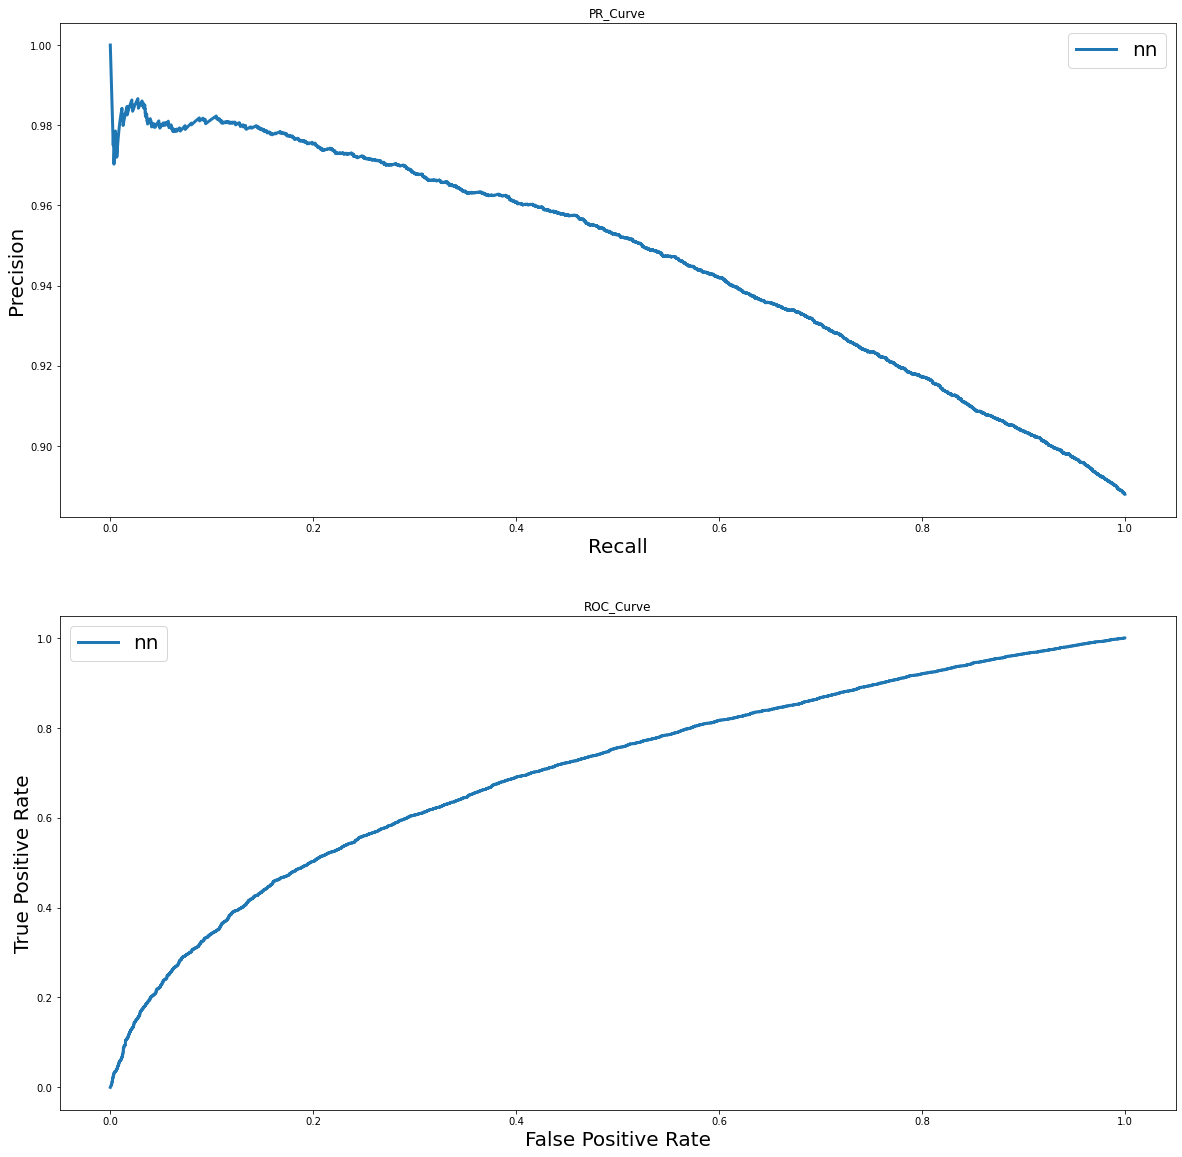

In [20]:
plot_Curve({"nn":nn_gmm_prob},y_test)

In [48]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def run_nn(X_train,X_test):
    
    # Images and their corresponding labels
    x_d = X_train.shape[1]
    fea = tf.placeholder(tf.float32, [None,x_d])
    ans = tf.placeholder(tf.float32, [None, 1])

    #den_0 = tf.layers.dense(inputs=fea, units=500, activation=tf.nn.relu)
    #den_0 = tf.nn.dropout(den_0,0.8)
    den_1 = tf.layers.dense(inputs=fea, units=200, activation=tf.nn.tanh)
    den_1 = tf.nn.dropout(den_1,0.8)
    den_2 = tf.layers.dense(inputs=den_1, units=100, activation=tf.nn.tanh)
    den_2 = tf.nn.dropout(den_2,0.8)
    den_3 = tf.layers.dense(inputs=den_2, units=30, activation=tf.nn.tanh)

    logits = tf.layers.dense(inputs=den_3, units=1)
    output = tf.nn.sigmoid(logits, name="sigmoid_tensor")
    # Forward passs -- compute the cross entropy and output probabilities
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=ans,logits=logits,weights = 0.1)


    # Backward pass
    # Note: you don't need to compute the gradient 
    # Simply use the tf.train.AdamOptimizer() function
    train = tf.train.AdamOptimizer(0.01).minimize(loss)

    # Compute Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1), tf.argmax(ans,1)),tf.float32))


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    from sklearn.utils import shuffle

    # Batch size for evaluation performance
    batchSz = 5000

    print("Training on 2000 batches:") 
    step = 500
    for i in range(step):
        if i % step == 0: sstart = time.time()  
        X_, y_ = shuffle(X_train, y_train)
        X_ = X_.values[:batchSz,:].reshape([batchSz,x_d])
        y_ = y_[:batchSz].values.reshape([batchSz,1])

        sess.run(train, feed_dict={fea: X_, ans: y_})
        if (i+1) % step == 0:
            sstop = time.time()
            print('batches %s - %d, duration ~ %g sec' % (i-(step-2), i+1, (sstop - sstart)))
        
    nn_prob = sess.run(output, feed_dict={fea: X_test, ans: y_test.values.reshape([y_test.shape[0],1])})
    nn_prob=[i[0] for i in nn_prob]
    nn_pred =[1 if i>0.5 else 0 for i in nn_prob] 
    nn_accuracy = sklearn.metrics.accuracy_score(y_test, nn_pred)
    print("Accuracy : ",nn_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,nn_pred))
    print(k)
    sess.close()
    
    return nn_prob
nn_nogmm_prob = run_nn(X_train_noGMM,X_test_noGMM)
nn_gmm_prob = run_nn(X_train,X_test)

Training on 2000 batches:
batches 1 - 500, duration ~ 92.2307 sec
Accuracy :  0.7061578774975434
      0      1
0  1973   1392
1  7579  19586
Training on 2000 batches:
batches 1 - 500, duration ~ 97.9607 sec
Accuracy :  0.7527677694071405
      0      1
0  1756   1609
1  5939  21226


In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def run_nn(X_train,X_test):
    
    # Images and their corresponding labels
    x_d = X_train.shape[1]
    fea = tf.placeholder(tf.float32, [None,x_d])
    ans = tf.placeholder(tf.float32, [None, 1])

    #den_0 = tf.layers.dense(inputs=fea, units=500, activation=tf.nn.relu)
    #den_0 = tf.nn.dropout(den_0,0.8)
    den_1 = tf.layers.dense(inputs=fea, units=200, activation=tf.nn.sigmoid)
    den_1 = tf.nn.dropout(den_1,0.8)
    den_2 = tf.layers.dense(inputs=den_1, units=100, activation=tf.nn.sigmoid)
    den_2 = tf.nn.dropout(den_2,0.8)
    den_3 = tf.layers.dense(inputs=den_2, units=30, activation=tf.nn.sigmoid)

    logits = tf.layers.dense(inputs=den_3, units=1)
    output = tf.nn.sigmoid(logits, name="sigmoid_tensor")
    # Forward passs -- compute the cross entropy and output probabilities
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=ans,logits=logits,weights = 0.1)


    # Backward pass
    # Note: you don't need to compute the gradient 
    # Simply use the tf.train.AdamOptimizer() function
    train = tf.train.AdamOptimizer(0.01).minimize(loss)

    # Compute Accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output,1), tf.argmax(ans,1)),tf.float32))


    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    from sklearn.utils import shuffle

    # Batch size for evaluation performance
    batchSz = 5000

    print("Training on 2000 batches:") 
    step = 500
    for i in range(step):
        if i % step == 0: sstart = time.time()  
        X_, y_ = shuffle(X_train, y_train)
        X_ = X_.values[:batchSz,:].reshape([batchSz,x_d])
        y_ = y_[:batchSz].values.reshape([batchSz,1])

        sess.run(train, feed_dict={fea: X_, ans: y_})
        if (i+1) % step == 0:
            sstop = time.time()
            print('batches %s - %d, duration ~ %g sec' % (i-(step-2), i+1, (sstop - sstart)))
        
    nn_prob = sess.run(output, feed_dict={fea: X_test, ans: y_test.values.reshape([y_test.shape[0],1])})
    nn_prob=[i[0] for i in nn_prob]
    nn_pred =[1 if i>0.5 else 0 for i in nn_prob] 
    nn_accuracy = sklearn.metrics.accuracy_score(y_test, nn_pred)
    print("Accuracy : ",nn_accuracy)
    k = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test,nn_pred))
    print(k)
    sess.close()
    
    return nn_prob
nn_nogmm_prob = run_nn(X_train_noGMM,X_test_noGMM)
nn_gmm_prob = run_nn(X_train,X_test)

Training on 2000 batches:
batches 1 - 500, duration ~ 86.5832 sec
Accuracy :  0.6951523092040616
      0      1
0  2027   1338
1  7969  19196
Training on 2000 batches:
batches 1 - 500, duration ~ 91.2914 sec
Accuracy :  0.7022273173927285
      0      1
0  2001   1364
1  7727  19438


In [ ]:
Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42,n_estimators=500)
random_forest.fit(X_train, y_train)
Yrandforest = random_forest.predict(X_test)

In [26]:
from sklearn.metrics import roc_curve

In [27]:
#Calculating the score,
scorey =random_forest.predict_proba(X_test)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_test, scorey)
#Checking the accuracy,

print(" Accuracy of Random forest classification: ", random_forest.score(X_test, y_test))

In [28]:
#Checking the accuracy,

print(" Accuracy of Random forest classification: ", random_forest.score(X_test, y_test))

 Accuracy of Random forest classification:  0.8831313462168359


In [29]:
X_train.shape

(126598, 139)